In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import trange

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step


2値分類の設定とするため、猫と犬の画像データだけを抽出してくる。

In [45]:
# 2つのクラスのみを選択する（例えば猫（3）と犬（5）を選択）
classes_to_use = [3, 5]
train_filter = np.isin(y_train, classes_to_use).flatten()
test_filter = np.isin(y_test, classes_to_use).flatten()

x_train_binary = x_train[train_filter]
y_train_binary = y_train[train_filter]
x_test_binary = x_test[test_filter]
y_test_binary = y_test[test_filter]

# ラベルを0と1に変換する（猫を0、犬を1とする）
y_train_binary = (y_train_binary == classes_to_use[1]).astype(np.int32)
y_test_binary = (y_test_binary == classes_to_use[1]).astype(np.int32)

# データの正規化（0-1の範囲）
x_train_binary = x_train_binary / 255.0
x_test_binary = x_test_binary / 255.0

(10000, 32, 32, 3)


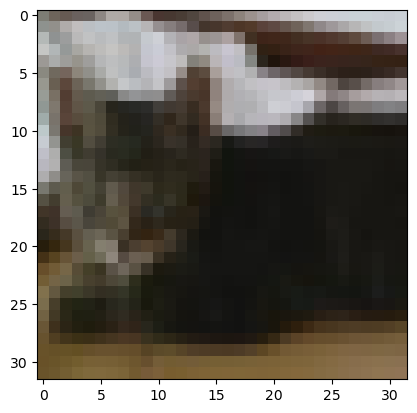

In [46]:
#犬と猫だけを抽出したデータセット
print(x_train_binary.shape)
#0番目の画像は猫
plt.imshow(x_train_binary[0])

単純なロジスティック回帰. y_pred = 1/(1 + exp(1 + w.x)) ただしwはパラメータ、xは学習データのベクトル,ピリオドはこの2つの内積を示す。

In [47]:
#ロジスティック回帰による二値分類
class MyClassifier:
    def __init__(self, learning_rate=0.01, batch_size=32):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.weights = None
        self.bias = None

    def preprocess(self, data):
        # 入力データをフラット化する
        return data.reshape(data.shape[0], -1)

    def sigmoid(self, z):
        # シグモイド関数
        return 1 / (1 + np.exp(-z))

    def train(self, X, y):
        # データの前処理
        X = self.preprocess(X)
        num_samples, num_features = X.shape

        # 重みとバイアスの初期化
        self.weights = np.zeros(num_features)
        self.bias = 0

        # エポック数の計算（全データを1回見渡すための最小エポック数）
        num_batches_per_epoch = num_samples // self.batch_size
        print("batch ",num_batches_per_epoch)
        if num_samples % self.batch_size != 0:
            num_batches_per_epoch += 1  # 端数を含む場合、追加で1バッチ

        # エポック数をバッチ数として動的に設定
        for epoch in trange(num_batches_per_epoch, desc="Training Progress"):
            # データをシャッフル
            indices = np.arange(num_samples)
            np.random.shuffle(indices)
            X = X[indices]
            y = y[indices]

            # バッチごとに学習
            start = (epoch * self.batch_size) % num_samples
            end = min(start + self.batch_size, num_samples)
            X_batch = X[start:end]
            y_batch = y[start:end].flatten()

            # バッチ全体での予測
            z = np.dot(X_batch, self.weights) + self.bias
            y_pred = self.sigmoid(z)

            # 勾配の計算
            error = y_pred - y_batch
            dw = np.dot(X_batch.T, error) / len(y_batch)
            db = np.sum(error) / len(y_batch)

            # パラメータの更新
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        # データの前処理
        X = self.preprocess(X)

        # 線形モデルの予測
        z = np.dot(X, self.weights) + self.bias
        y_pred = self.sigmoid(z)

        # クラスの割り当て（0 または 1）
        return (y_pred >= 0.5).astype(int)

In [52]:
# MyClassifierのインポートと初期化
classifier = MyClassifier(learning_rate=0.01, batch_size=32)

# トレーニング
classifier.train(x_train_binary, y_train_binary)

batch  312


Training Progress: 100%|██████████| 313/313 [00:12<00:00, 24.36it/s]


In [53]:
# モデルの評価
y_pred = classifier.predict(x_test_binary)

# 精度の計算
accuracy = np.mean(y_pred == y_test_binary.flatten())
print(f"Test Accuracy: {accuracy:.2f}")


Test Accuracy: 0.57


実行時間13秒、Accuracy 57%...データ数10000では少ないか。
こんどは単純な内積w.xじゃなくて、RBFを使って100000次元のベクトル$\phi (x_i) = K(x_i,x_j)$に変換して、これに対してlogit損失関数で学習してみる。

In [54]:
#ロジスティック回帰、RBFカーネルを導入した二値分類
class MyClassifier_RBF:
    def __init__(self, learning_rate=0.01, batch_size=32, gamma=0.1):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.gamma = gamma
        self.alpha = None  # RBFカーネルの重み
        self.bias = 0
        self.X_train = None  # トレーニングデータ全体を保持

    def preprocess(self, data):
        # 入力データをフラット化する
        return data.reshape(data.shape[0], -1)

    def sigmoid(self, z):
        # シグモイド関数
        return 1 / (1 + np.exp(-z))

    def rbf_kernel(self, xi, xj):
        # RBFカーネルの計算
        return np.exp(-self.gamma * np.linalg.norm(xi - xj) ** 2)

    def train(self, X, y):
        # データの前処理
        X = self.preprocess(X)
        self.X_train = X
        self.y_train = y.flatten()

        num_samples = X.shape[0]

        # 重みはトレーニングデータの各データポイントに対応（αを全データ数分用意）
        self.alpha = np.zeros(num_samples)
        self.bias = 0

        # エポック数の計算（全データを1回見渡すための最小エポック数）
        num_batches_per_epoch = num_samples // self.batch_size
        if num_samples % self.batch_size != 0:
            num_batches_per_epoch += 1  # 端数を含む場合、追加で1バッチ

        # エポックごとに学習を実行
        for epoch in trange(num_batches_per_epoch, desc="Training Progress"):
            # データをシャッフル
            indices = np.arange(num_samples)
            np.random.shuffle(indices)
            X = X[indices]
            y = y[indices]

            # バッチごとに学習
            start = (epoch * self.batch_size) % num_samples
            end = min(start + self.batch_size, num_samples)
            X_batch = X[start:end]
            y_batch = y[start:end]

            # 各バッチ内の各データポイントについて学習
            for i in range(len(X_batch)):
                xi = X_batch[i]
                yi = y_batch[i]

                # RBFカーネルによる線形和の計算
                z = 0
                for j in range(num_samples):
                    k_ij = self.rbf_kernel(xi, self.X_train[j])
                    z += self.alpha[j] * k_ij
                z += self.bias

                # シグモイド関数を使って予測値を計算
                y_pred = self.sigmoid(z)

                # 勾配の計算
                error = y_pred - yi
                for j in range(num_samples):
                    k_ij = self.rbf_kernel(xi, self.X_train[j])
                    self.alpha[j] -= self.learning_rate * error * k_ij
                self.bias -= self.learning_rate * error

    def predict(self, X):
        # データの前処理
        X = self.preprocess(X)
        num_samples = self.X_train.shape[0]
        y_pred = []

        # 各データポイントについて予測
        for xi in X:
            # RBFカーネルによる線形和の計算
            z = 0
            for j in range(num_samples):
                k_ij = self.rbf_kernel(xi, self.X_train[j])
                z += self.alpha[j] * k_ij
            z += self.bias

            # シグモイド関数を使って予測値を計算
            prob = self.sigmoid(z)
            y_pred.append(1 if prob >= 0.5 else 0)

        return np.array(y_pred)

In [55]:
# MyClassifierのインポートと初期化
classifier = MyClassifier_RBF(learning_rate=0.01, batch_size=32)

# トレーニング
classifier.train(x_train_binary, y_train_binary)

Training Progress:   0%|          | 0/313 [00:00<?, ?it/s]/var/folders/ts/jr_9pm0d7pq0vy46pp2qv7gh0000gp/T/ipykernel_54918/69679987.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.alpha[j] -= self.learning_rate * error * k_ij
Training Progress: 100%|██████████| 313/313 [16:49<00:00,  3.23s/it]


In [56]:
# モデルの評価
y_pred = classifier.predict(x_test_binary)

# 精度の計算
accuracy = np.mean(y_pred == y_test_binary.flatten())
print(f"Test Accuracy: {accuracy:.2f}")

Test Accuracy: 0.50


In [ ]:
16分かけてaccuracyが0.5とは。そもそもlearning_rateも適切な値がわからないし、RBFカーネルを使ってどうこうという話でもない。